*Luis Antonio Ortega Andrés    
Antonio Coín Castro*

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, IBMQ, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_textbook.tools import array_to_latex

%matplotlib inline

# Load IBM account
provider = IBMQ.load_account()

/home/antcc/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Entrelazamiento cuántico

Vamos a estudiar un circuito de dos qubits que produce como salida una función de onda entrelazada. Esto significa, en resumidas cuentas, que si medimos uno de los dos qubits de la salida, el otro que no hemos medido también colapsa y queda totalmente determinado.

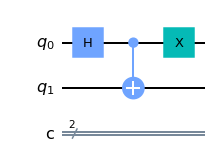

In [2]:
# Create a 2-qubit circuit
circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cnot(0, 1)
circuit.x(0)

circuit.draw(output='mpl')

En primer lugar, vamos a estudiar analíticamente el circuito. Lo haremos utilizando los estados conjuntos, es decir, siguiendo el rastro a los dos qubits a la vez. Recordemos que para puertas en serie el producto de matrices debe hacerse en el orden inverso al que aparecen las puertas, y también que dadas dos puertas en paralelo $U_1$ y $U_2$, se tiene

$$U_1|\psi\rangle \otimes U_2|\varphi\rangle= (U_1\otimes U_2)|\psi \otimes \varphi\rangle.$$

Consideramos los estados iniciales $|q_0\rangle=|q_1\rangle=|0\rangle$. Leeremos el circuito al revés para aplicar las transformaciones en el orden correcto.

- Lo primero es entonces aplicar una puerta NOT al primer qubit, y la transformación identidad al segundo:

$$U_1=X \otimes I = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}\otimes \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} = \begin{pmatrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\ 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \end{pmatrix}.$$

- Después aplicamos una puerta CNOT al resultado, entendiendo que el primer qubit es el de control:

$$U_2=\begin{pmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0 \end{pmatrix}.$$

- Finalmente aplicamos una puerta de Hadamard a $q_0$ y la transformación identidad a $q_1$. 

$$
U_3 = H\otimes I = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}\otimes  \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}= \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 0 & 1 & 0\\ 0 & 1 & 0 & 1\\ 1 & 0 & -1 & 0\\ 0 & 1 & 0 & -1 \end{pmatrix}.
$$

- Concatenamos todas las operaciones realizadas:

$$U=U_1U_2U_3.$$

Por lo tanto, aplicar todo el circuito es equivalente a:

$$
\begin{aligned}
U|00\rangle&= \frac{1}{\sqrt{2}}\begin{pmatrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\ 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \end{pmatrix}
\begin{pmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\ 0 & 0 & 0 & 1\\ 0 & 0 & 1 & 0 \end{pmatrix}
\begin{pmatrix}1 & 0 & 1 & 0\\ 0 & 1 & 0 & 1\\ 1 & 0 & -1 & 0\\ 0 & 1 & 0 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}\\
&=\frac{1}{\sqrt{2}}\begin{pmatrix}0 & 0 & 0 & 1\\0 & 0 & 1 & 0\\ 1 & 0 & 0 & 0\\ 0 & 1 & 0 & 0 \end{pmatrix}
\begin{pmatrix}1 & 0 & 1 & 0\\ 0 & 1 & 0 & 1\\ 1 & 0 & -1 & 0\\ 0 & 1 & 0 & -1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}\\
&= \frac{1}{\sqrt{2}}\begin{pmatrix}0 & 1 & 0 & -1\\ 1 & 0 & -1 & 0\\ 1 & 0 & 1 & 0\\ 0 & 1 & 0 & 1 \end{pmatrix} \begin{pmatrix} 1 \\ 0 \\ 0 \\ 0 \end{pmatrix}\\
&=\frac{1}{\sqrt{2}}\begin{pmatrix} 0 \\ 1 \\ 1 \\ 0 \end{pmatrix}=\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle.
\end{aligned}
$$

Por tanto, a la salida mediremos uno de los estados $|01\rangle$ o $|10\rangle$, con la misma probabilidad $\left|\frac{1}{\sqrt{2}}\right|^2= \frac{1}{2}.$ Además, nos damos cuenta de que si medimos el primer qubit, el segundo qubit queda totalmente determinado: si el primer qubit resulta ser $|0\rangle$, el segundo necesariamente será $|1\rangle$, y viceversa, ya que el resto de estados tienen probabilidad $0$ de ocurrir.


Mostramos la matriz unitaria del circuito, que podemos comprobar que coincide con la que hemos calculado (convenientemente permutada para seguir la convención de Qiskit de leer los circuitos de abajo hacia arriba).

In [3]:
backend_unitary = Aer.get_backend('unitary_simulator')
matrix = execute(circuit, backend_unitary).result().get_unitary(decimals=3)
print("Circuit unitary gate (following Qiskit convention):\n", matrix)

Circuit unitary gate (following Qiskit convention):
 [[ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j]
 [ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]]


Podemos ver también cuál es la superposición de estados del circuito antes de la medición.

<IPython.core.display.Math object>

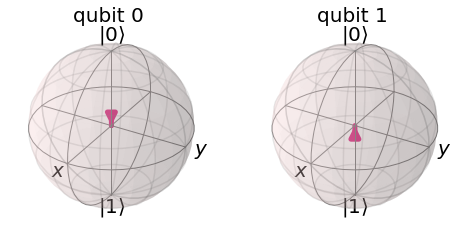

In [4]:
backend = Aer.get_backend('statevector_simulator')
psi = execute(circuit, backend).result().get_statevector()
array_to_latex(psi, pretext="\\text{Statevector = }")
plot_bloch_multivector(psi)

Deducimos de las posiciones en la esfera de Bloch que en principio ambos qubits tienen equiprobabilidad de ser medidos a $|0\rangle$ y a $|1\rangle$, de manera independiente. Pero veamos qué ocurre si medimos únicamente el primer qubit:

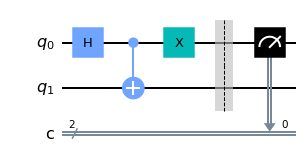

In [5]:
circuit.barrier()
circuit.measure(0, 0)
circuit.draw('mpl')

<IPython.core.display.Math object>

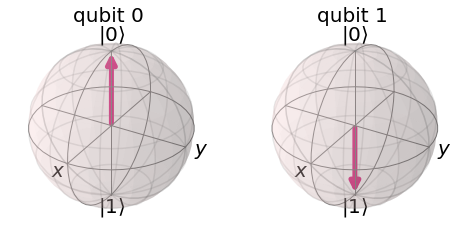

In [9]:
psi1 = execute(circuit, backend).result().get_statevector()
array_to_latex(psi1, pretext="\\text{Statevector = }")
plot_bloch_multivector(psi1)

Como vemos, el primer qubit ha resultado ser $|0\rangle$, y **aunque no hemos medido el segundo qubit**, este ha colapsado al valor $|1\rangle$ (ya que se encontraban entrelazados; el estado $|00\rangle$ nunca podía ocurrir). Lo análogo hubiera ocurrido si hubiésemos medido primero $q_1$. Podemos ejecutar el circuito y comprobar que los resultados son los esperados, es decir, que obtenemos los estados $|01\rangle$ y $|10\rangle$ con la misma probabilidad, y los otros dos estados nunca ocurren.

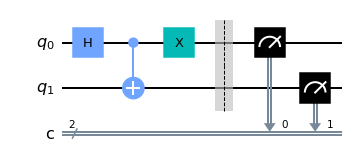

In [7]:
circuit.measure(1, 1)
circuit.draw('mpl')

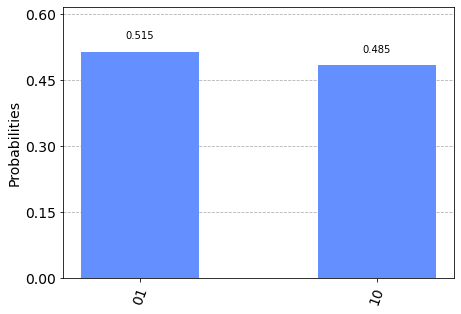

In [11]:
backend_sim = provider.get_backend('ibmq_qasm_simulator')
result = execute(circuit, backend_sim, shots=1024).result()
counts = result.get_counts(circuit)
plot_histogram(counts)

## Demostración matemática del entrelazamiento

Demostramos ahora formalmente que el estado resultado $\frac{1}{\sqrt{2}}|01\rangle + \frac{1}{\sqrt{2}}|10\rangle$ es un estado entrelazado. Para ello veremos que no se puede descomponer como producto tensor de dos estados básicos. Supongamos lo contrario, es decir, existen $a,b,c,d\in \mathbb C$ tales que 

$$
\frac{1}{\sqrt{2}}\begin{pmatrix} 0 \\ 1 \\ 1 \\ 0 \end{pmatrix} = \begin{pmatrix} a\\ b  \end{pmatrix} \otimes \begin{pmatrix} c \\ d \end{pmatrix} = \begin{pmatrix} ac \\ ad \\ bc \\ bd \end{pmatrix}.
$$

Igualando término a término, obtenemos que
$$
\begin{cases}ad =\frac{1}{\sqrt{2}} \neq 0 \implies a,d\neq 0\\
bc = \frac{1}{\sqrt{2}} \neq 0 \implies b,c \neq 0.
\end{cases}
$$

Pero por otro lado, también debe darse $ac=0$, por lo que o bien $a=0$ o bien $c=0$, lo cual contradice las condiciones anteriores. Por tanto, el estado no se puede descomponer como producto tensor de estados básicos, y es entrelazado.